In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random

In [2]:
torch.__version__

'1.12.1'

## basic ELM

In [3]:
class ELM(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        # default_args
        self.args = {
            'input_dim': 32,                   # 输入层维度为 32
            'output_dim': 24,                  # 输出层维度为 24
            'hidden_dim': 64,                   # 隐藏层维度为 8
            'activation_fun': 'sigmoid'        # 激活函数为 sigmoid
        }

        self.args.update(kwargs)              # 用 kwargs 更新默认参数

        self.activation_fun = getattr(F, self.args["activation_fun"])  # 获取指定的激活函数

        self.fc1 = nn.Linear(self.args['input_dim'], self.args['hidden_dim'])   # 定义一个全连接层
        self.fc2 = nn.Linear(self.args['hidden_dim'], self.args['output_dim'], bias=False) # 定义另一个全连接层，输出层不需要偏置

    def forward(self, x):
        with torch.no_grad():   # 不需要反向传播，因此使用 no_grad() 上下文管理器，以减少内存消耗
            x = self.activation_fun(self.fc1(x))   # 计算隐藏层的输出
            return self.fc2(x)                      # 计算输出层的输出
        
    def fit(self, data, ground_truth):
        # 给定 N 条 data 和对应的 ground_truth，更新 fc2 的参数
        
        with torch.no_grad():   # 不需要反向传播，同样使用 no_grad() 上下文管理器
            hidden_mat = self.activation_fun(self.fc1(data))  # 计算隐藏层的输出

            beta = torch.matmul(torch.pinverse(hidden_mat), ground_truth)  # 计算 H 的广义逆，求解 beta
            self.fc2.weight = nn.Parameter(beta.T)    # 将 beta 转置后，作为新的权重更新 fc2```的参数


## TELM

In [4]:
class TELM(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        # default_args
        self.args = {
            'input_dim': 32,                   # 输入层维度为 32
            'output_dim': 24,                  # 输出层维度为 24
            'hidden_dim': 64,                   # 隐藏层维度为 8
            # 'activation_fun': 'sigmoid'        # 激活函数为 sigmoid
        }

        self.args.update(kwargs)              # 用 kwargs 更新默认参数

        # self.activation_fun = getattr(F, self.args["activation_fun"])  # 获取指定的激活函数

        self.fc1 = nn.Linear(self.args['input_dim'], self.args['hidden_dim'])   # 输入层
        self.fc2 = nn.Linear(self.args['hidden_dim'], self.args['hidden_dim'])   # 中间层
        self.fc3 = nn.Linear(self.args['hidden_dim'], self.args['output_dim'], bias=False) # 输出层，不需要偏置

    def DSIG(self, x):
        '''activate fun'''
        return (1-torch.exp(-x))/(1+torch.exp(-x))

    def DSIG_reverse(self, x):
        # return torch.log(2/(1-x))
        return -torch.log((1-x+1e-5)/(1+x+1e-5))

    def forward(self, x):
        with torch.no_grad():   # 不需要反向传播，因此使用 no_grad() 上下文管理器，以减少内存消耗
            x = self.DSIG(self.fc1(x))
            # x = self.DSIG(self.fc2(x))
            return self.fc3(x)                      
        
    def fit(self, data, ground_truth):
        # 给定 N 条 data 和对应的 ground_truth，更新 fc2 的参数
        
        with torch.no_grad():   # 不需要反向传播，同样使用 no_grad() 上下文管理器
            b = data.shape[0]

            # 求beta
                                                        # batch, input_dim
            hidden_mat_1 = self.DSIG(self.fc1(data))    # batch, hidden_dim
            beta = torch.matmul(torch.pinverse(hidden_mat_1), ground_truth)  # 计算 H 的广义逆，求解 beta
            self.fc3.weight = nn.Parameter(beta.T)    # 将 beta 转置后，作为新的权重更新 fc3的参数

            # 求θ和bias
            hidden_cat_one = torch.pinverse(torch.cat((hidden_mat_1,torch.ones(b,self.args['hidden_dim'])), dim=1))
            reverse_target_mul_betaR = self.DSIG_reverse(torch.matmul(ground_truth, torch.pinverse(beta)))
            theta_and_bias = torch.matmul(hidden_cat_one, reverse_target_mul_betaR)
            theta = theta_and_bias[0:self.args['hidden_dim']]
            bias = theta_and_bias[self.args['hidden_dim']:].sum(dim=0)

            self.fc2.weight = nn.Parameter(theta.T)    # 将 theta 转置后，作为新的权重更新 fc3的参数
            self.fc2.bias = nn.Parameter(bias)

## 处理svc数据

In [5]:
def read_SVC_data(file_path, index=False, norm=True):
    df = pd.read_excel(file_path, header=None)
    data = torch.tensor(df.iloc[2:].values.astype(float), dtype=torch.float32)
    target = torch.tensor(df.iloc[1].values.astype(float), dtype=torch.float32).unsqueeze(1)

    if index:
        avg_pool = nn.AvgPool1d(15,15,1)
        data = data.transpose(0,1)
        pooled_data = avg_pool(data.unsqueeze(1)).squeeze(1)
        NDI = (pooled_data.unsqueeze(1)-pooled_data.unsqueeze(2))/(pooled_data.unsqueeze(1)+pooled_data.unsqueeze(2)+1e-5)
        NRI = pooled_data.unsqueeze(1)/(pooled_data.unsqueeze(2)+pooled_data.unsqueeze(1)+1e-5)      # The division operation results in 
                                                                        # a wide range of RI values, +self in the denominator to 
                                                                        # stabilizes the model performance

        NDI = torch.tril(NDI)
        NRI = torch.triu(NRI)
        INDEX = NDI + NRI
        return INDEX.view(-1, 65 ** 2), target

    # min-max normalization
    data_min = torch.min(data, dim=0)[0]
    data_max = torch.max(data, dim=0)[0]
    data_norm = (data - data_min) / (data_max - data_min)
    if not norm:
        return data.transpose(0,1), target
    else:
        return data_norm.transpose(0,1), target

In [6]:
data, target = read_SVC_data("C:\\Users\\29147\\Documents\\WeChat Files\\wxid_7301883019012\\FileStorage\\File\\2023-05\\原始数据.xlsx", index=True)

In [7]:
data.shape

torch.Size([533, 4225])

## 拆分数据集

In [8]:
# 按照ground truth的大小对数据进行降序排序
sorted_indices = torch.argsort(target, dim=0, descending=False).squeeze()
data_sorted = data[sorted_indices]
target_sorted = target[sorted_indices]

# 分割成5个子数据集，每个数据集中的品位分布大致相同
n_splits = 5 # 分割的份数

sub_data = []
sub_ground_truth = []

for i in range(n_splits):
    sub_ground_truth.append([])
    sub_data.append([])


for idx in range(data_sorted.__len__()):
    sub_data[idx%n_splits].append(data_sorted[idx].unsqueeze(0))
    sub_ground_truth[idx%n_splits].append(target_sorted[idx])


# 将数据和标签从list转回tensor
for i in range(n_splits):
    sub_ground_truth[i] = torch.as_tensor(sub_ground_truth[i], dtype=torch.float32)
    sub_data[i] = torch.cat(sub_data[i], dim=0)

# sub_ground_truth = torch.cat(sub_ground_truth, dim=0)
# sub_data = torch.cat(sub_data, dim=0)

# 姑且先用最后一个当验证集，不交叉验证了，写着麻烦
train_data = torch.cat(sub_data[0:n_splits-1])
train_gt = torch.cat(sub_ground_truth[0:n_splits-1]).unsqueeze(1)

val_data = torch.cat(sub_data[n_splits-1:])
val_gt = torch.cat(sub_ground_truth[n_splits-1:]).unsqueeze(1)


In [9]:
# # 创建elm模型对象
# model_elm = ELM(input_dim=973, hidden_dim=2300, output_dim=1)
# model_telm = TELM(input_dim=973, hidden_dim=2300, output_dim=1)

In [10]:
# # 训练
# model_elm.fit(train_data, train_gt)
# model_telm.fit(train_data, train_gt)

In [11]:
# # 我随便挑几条数据测试（这块我懒得写了）
# random_number = random.randint(450, 532)
# # random_number = random.randint(0, 533)

# pred1 = model_elm(data[random_number].unsqueeze(0))
# pred2 = model_telm(data[random_number].unsqueeze(0))
# ground_truth = target[random_number]

# print("真值：{}， elm预测：{}，telm预测：{}".format(ground_truth, pred1, pred2))

## 评估过程

In [12]:
train_data.shape

torch.Size([213, 4225])

In [13]:
# pred_elm = model_elm(val_data)
# pred_telm = model_telm(val_data)

In [14]:
# 定义R方的函数
def r2_score(output, target):
    mean_target = torch.mean(target)
    ss_tot = torch.sum((target - mean_target) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# 定义Rmse的函数
def rmse(output, target):
    mse = torch.nn.MSELoss()
    return torch.sqrt(mse(output, target))

# 定义评估方法
def evaluation(pred, ground_truth):
    '''
    评估mae和r2
    params:
        pred:预测
        ground_truth:标签
    '''
    # 定义平均绝对误差的损失函数
    l1_loss = torch.nn.L1Loss()

    # 计算平均绝对误差
    mae = l1_loss(ground_truth, pred)
    # 计算R方
    r2 = rmse(pred, ground_truth)

    return mae, r2
    

In [15]:
# evaluation(pred_elm, val_gt)

In [16]:
# evaluation(pred_telm, val_gt)

In [17]:
# 定义画图函数

import matplotlib.pyplot as plt

def plot_mae_r2(mae_elm, r2_elm, mae_telm, r2_telm):
  # 创建一个一行两列的画布
  fig, (ax1, ax2) = plt.subplots(1, 2)
  # 设置画布大小
  fig.set_size_inches(10, 5)
  # 设置左侧子图的标题和坐标轴标签
  ax1.set_title("MAE")
  ax1.set_xlabel("hidden size")
  ax1.set_ylabel("MAE")
  # 设置左侧子图的横坐标刻度间隔为1000
#   ax1.xaxis.set_ticks(range(0, max(mae_elm[0], mae_telm[0]) + 1000, 1000))
  # 在左侧子图上画两条线段，分别对应ELM和TELM的MAE
  ax1.plot(mae_elm[0], mae_elm[1], color="blue", label="ELM")
  ax1.plot(mae_telm[0], mae_telm[1], color="red", label="TELM")
  # 显示左侧子图的图例
  ax1.legend()
  # 设置右侧子图的标题和坐标轴标签
  ax2.set_title("R2")
  ax2.set_xlabel("hidden size")
  ax2.set_ylabel("R2")
  # 设置右侧子图的横坐标刻度间隔为1000
  # ax2.xaxis.set_ticks(range(0, max(r2_elm[0], r2_telm[0]) + 1000, 1000))
  # 在右侧子图上画两条线段，分别对应ELM和TELM的R2
  ax2.plot(r2_elm[0], r2_elm[1], color="blue", label="ELM")
  ax2.plot(r2_telm[0], r2_telm[1], color="red", label="TELM")
  # 显示右侧子图的图例
  ax2.legend()
  # 显示整个画布
  plt.show()

## 尝试不同hidden size并给出评估曲线

c:\ProgramData\Miniconda3\envs\VC\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


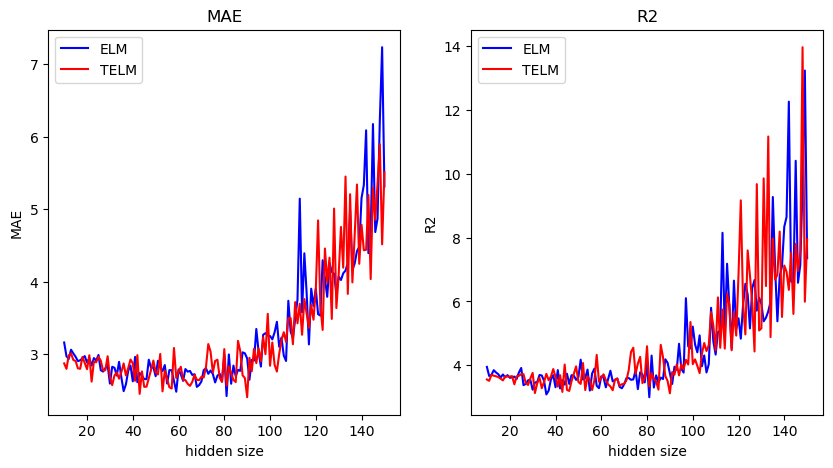

In [18]:
mae_elm = [[],[]]
r2_elm = [[],[]]
mae_telm = [[],[]]
r2_telm = [[],[]]


hidden_size_start = 10
hidden_size_end = 150


hidden_size_cur = hidden_size_start
while hidden_size_cur <= hidden_size_end:
  mae_elm[0].append(hidden_size_cur)
  r2_elm[0].append(hidden_size_cur)
  mae_telm[0].append(hidden_size_cur)
  r2_telm[0].append(hidden_size_cur)


  # 创建elm模型对象
  model_elm = ELM(input_dim=4225, hidden_dim=hidden_size_cur, output_dim=1)
  model_telm = TELM(input_dim=4225, hidden_dim=hidden_size_cur, output_dim=1)
  # 训练
  model_elm.fit(train_data, train_gt)
  model_telm.fit(train_data, train_gt)

  # 评估
  pred_elm = model_elm(val_data)
  pred_telm = model_telm(val_data)

  mae, r2 = evaluation(pred_elm, val_gt)
  mae_elm[1].append(mae)
  r2_elm[1].append(r2)

  mae, r2 = evaluation(pred_telm, val_gt)
  mae_telm[1].append(mae)
  r2_telm[1].append(r2)
  
  # 设置间隔为200
  hidden_size_cur += 1


plot_mae_r2(mae_elm, r2_elm, mae_telm, r2_telm)

In [19]:
# 创建elm模型对象
model_elm = ELM(input_dim=4225, hidden_dim=3000, output_dim=1)
model_telm = TELM(input_dim=4225, hidden_dim=3000, output_dim=1)
# 训练
model_elm.fit(train_data, train_gt)
model_telm.fit(train_data, train_gt)

# 评估
pred_elm = model_elm(val_data)
pred_telm = model_telm(val_data)

In [20]:
torch.abs(pred_telm-val_gt).mean()

tensor(8.2164)

In [21]:
l1_loss = torch.nn.L1Loss()

In [22]:
l1_loss(pred_telm, val_gt)

tensor(8.2164)

In [23]:
for i in range(pred_telm.__len__()):
    print("真值：{}， elm预测：{}，telm预测：{}".format(val_gt[i], pred_elm[i], pred_telm[i]))

真值：tensor([12.7000])， elm预测：tensor([14.4131])，telm预测：tensor([16.6602])
真值：tensor([15.2200])， elm预测：tensor([18.6934])，telm预测：tensor([23.4336])
真值：tensor([15.5000])， elm预测：tensor([6.3105])，telm预测：tensor([6.5508])
真值：tensor([16.3300])， elm预测：tensor([2.5996])，telm预测：tensor([3.7891])
真值：tensor([17.0300])， elm预测：tensor([2.7314])，telm预测：tensor([4.8555])
真值：tensor([17.5900])， elm预测：tensor([28.6094])，telm预测：tensor([28.7539])
真值：tensor([18.4300])， elm预测：tensor([17.6680])，telm预测：tensor([15.8359])
真值：tensor([18.7100])， elm预测：tensor([31.6387])，telm预测：tensor([26.2188])
真值：tensor([19.1300])， elm预测：tensor([16.9844])，telm预测：tensor([23.0703])
真值：tensor([19.2600])， elm预测：tensor([23.0859])，telm预测：tensor([22.2656])
真值：tensor([19.8200])， elm预测：tensor([32.8574])，telm预测：tensor([29.1055])
真值：tensor([19.9600])， elm预测：tensor([22.4502])，telm预测：tensor([23.5820])
真值：tensor([19.9600])， elm预测：tensor([26.7520])，telm预测：tensor([27.7734])
真值：tensor([20.3800])， elm预测：tensor([40.6670])，telm预测：tensor([38.8164])
真值：tensor([2

In [24]:
pred_telm.shape

torch.Size([106, 1])